In [1]:
import requests
import json
import numpy as np
import matplotlib.pyplot as plt

In [17]:
import struct
import serial


class Lens:
    def __init__(self, port, debug=False):
        self.debug = debug

        self.connection = serial.Serial(port, 115200, timeout=1)
        self.connection.flush()

        self.connection.write(b"Start")
        if not self.connection.readline() == b"Ready\r\n":
            raise Exception("Lens Driver did not reply to handshake")

        self.firmware_type = self.get_firmware_type()
        self.firmware_version = self.get_firmware_version()

        self.device_id = self.get_device_id()
        self.max_output_current = self.get_max_output_current()
        self.set_temperature_limits(20, 40)

        self.mode = None
        self.refresh_active_mode()

        self.lens_serial = self.get_lens_serial_number()

        if self.debug:
            print(
                "=== Lens initialization complete =================================================================="
            )

    def send_command(self, command, reply_fmt=None):
        if type(command) is not bytes:
            command = bytes(command, encoding="ascii")
        command = command + struct.pack("<H", crc_16(command))
        if self.debug:
            commandhex = " ".join("{:02x}".format(c) for c in command)
            print("{:<50} ¦ {}".format(commandhex, command))
        self.connection.write(command)

        if reply_fmt is not None:
            response_size = struct.calcsize(reply_fmt)
            response = self.connection.read(response_size + 4)
            if self.debug:
                responsehex = " ".join("{:02x}".format(c) for c in response)
                print("{:>50} ¦ {}".format(responsehex, response))

            if response is None:
                raise Exception("Expected response not received")

            data, crc, newline = struct.unpack(
                "<{}sH2s".format(response_size), response
            )
            if crc != crc_16(data) or newline != b"\r\n":
                raise Exception("Response CRC not correct")

            return struct.unpack(reply_fmt, data)

    def get_max_output_current(self):
        return self.send_command("CrMA\x00\x00", ">xxxh")[0] / 100

    def get_firmware_type(self):
        return self.send_command("H", ">xs")[0].decode("ascii")

    def get_firmware_branch(self):
        return self.send_command("F", ">xB")[0]

    def get_device_id(self):
        return self.send_command("IR\x00\x00\x00\x00\x00\x00\x00\x00", ">xx8s")[
            0
        ].decode("ascii")

    def get_firmware_version(self):
        return self.send_command(b"V\x00", ">xBBHH")

    def get_lens_serial_number(self):
        return self.send_command("X", ">x8s")[0].decode("ascii")

    def eeprom_write_byte(self, address, byte):
        return self.send_command(b"Zw" + struct.pack("BB", address, byte), ">xB")[0]

    def eeprom_dump(self):
        return [
            self.send_command(b"Zr" + struct.pack("B", i), ">xB")[0] for i in range(256)
        ]

    def eeprom_print(self):
        eeprom = self.eeprom_dump()

        print("===============================================")
        print("EEPROM of lens number {}".format(self.lens_serial))
        print("===============================================")
        for i in range(16):
            print(
                " ".join(
                    ["{:02x}".format(byte) for byte in eeprom[i * 16 : i * 16 + 16]]
                )
            )
        print("===============================================")

    def get_temperature(self):
        return self.send_command(b"TCA", ">xxxh")[0] * 0.0625

    def set_temperature_limits(self, lower, upper):
        error, max_fp, min_fp = self.send_command(
            b"PwTA" + struct.pack(">hh", upper * 16, lower * 16), ">xxBhh"
        )
        if self.firmware_type == "A":
            return error, min_fp / 200 - 5, max_fp / 200 - 5
        else:
            return error, min_fp / 200, max_fp / 200

    def get_current(self):
        return (
            self.send_command(b"Ar\x00\x00", ">xh")[0] * self.max_output_current / 4095
        )

    def set_current(self, current):
        if not self.mode == 1:
            raise Exception("Cannot set current when not in current mode")
        raw_current = int(current * 4095 / self.max_output_current)
        self.send_command(b"Aw" + struct.pack(">h", raw_current))

    def get_diopter(self):
        (raw_diopter,) = self.send_command(b"PrDA\x00\x00\x00\x00", ">xxh")
        return raw_diopter / 200 - 5 if self.firmware_type == "A" else raw_diopter / 200

    def set_diopter(self, diopter):
        if not self.mode == 5:
            raise Exception("Cannot set focal power when not in focal power mode")
        raw_diopter = int(
            (diopter + 5) * 200 if self.firmware_type == "A" else diopter * 200
        )
        self.send_command(b"PwDA" + struct.pack(">h", raw_diopter) + b"\x00\x00")

    def to_focal_power_mode(self):
        error, max_fp_raw, min_fp_raw = self.send_command("MwCA", ">xxxBhh")
        min_fp, max_fp = min_fp_raw / 200, max_fp_raw / 200
        if self.firmware_type == "A":
            min_fp, max_fp = min_fp - 5, max_fp - 5

        self.refresh_active_mode()
        return min_fp, max_fp

    def to_current_mode(self):
        self.send_command("MwDA", ">xxx")
        self.refresh_active_mode()

    def refresh_active_mode(self):
        self.mode = self.send_command("MMA", ">xxxB")[0]
        return self.mode


def crc_16(s):
    crc = 0x0000
    for c in s:
        crc = crc ^ c
        for i in range(0, 8):
            crc = (crc >> 1) ^ 0xA001 if (crc & 1) > 0 else crc >> 1

    return crc

In [2]:
DATA_PREFIX = "data: "


def parse_chunk(chunk):
    lines = chunk.strip().split("\n")
    assert len(lines) == 2
    assert lines[0] == "event: braid"
    assert lines[1].startswith(DATA_PREFIX)
    buf = lines[1][len(DATA_PREFIX) :]
    data = json.loads(buf)
    return data

0.3316012564660397


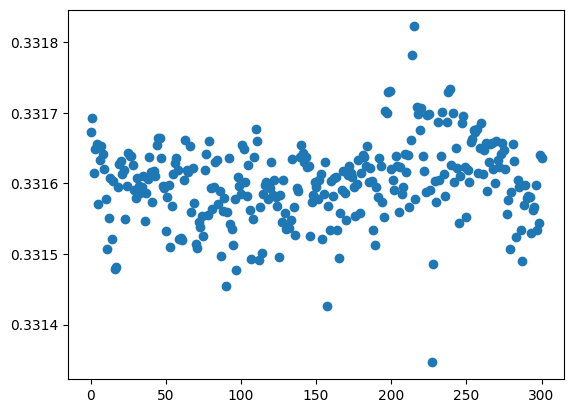

In [91]:
braid_url = "http://127.0.0.1:8397/"
events_url = f"{braid_url}/events"
session = requests.Session()
r = session.get(braid_url)
assert r.status_code == requests.codes.ok

r = session.get(events_url, stream=True, headers={"Accept": "text/event-stream"})

i = 0
zs = []

for chunk in r.iter_content(chunk_size=None, decode_unicode=True):
    if i > 300:
        break

    data = parse_chunk(chunk)
    try:
        z = data["msg"]["Update"]["z"]
        zs.append(z)
        i += 1
    except:
        pass

print(np.nanmean(zs))

fig = plt.figure()
plt.scatter(range(len(zs)), zs)
plt.show()

In [20]:
lens = Lens("/dev/optotune_ld", debug=True)
lens.to_focal_power_mode()

48 00 36                                           ¦ b'H\x006'
                                 48 46 b7 f2 0d 0a ¦ b'HF\xb7\xf2\r\n'
56 00 3f a0                                        ¦ b'V\x00?\xa0'
                  56 01 09 08 11 e4 59 32 8a 0d 0a ¦ b'V\x01\t\x08\x11\xe4Y2\x8a\r\n'
49 52 00 00 00 00 00 00 00 00 37 98                ¦ b'IR\x00\x00\x00\x00\x00\x00\x00\x007\x98'
         49 52 41 4b 41 42 35 33 37 39 57 9f 0d 0a ¦ b'IRAKAB5379W\x9f\r\n'
43 72 4d 41 00 00 71 80                            ¦ b'CrMA\x00\x00q\x80'
                        43 4d 41 72 64 27 fc 0d 0a ¦ b"CMArd'\xfc\r\n"
50 77 54 41 02 80 01 40 33 d0                      ¦ b'PwTA\x02\x80\x01@3\xd0'
                  50 54 00 03 64 fc 7c 5c ab 0d 0a ¦ b'PT\x00\x03d\xfc|\\\xab\r\n'
4d 4d 41 65 77                                     ¦ b'MMAew'
                           4d 4d 41 01 76 eb 0d 0a ¦ b'MMA\x01v\xeb\r\n'
58 01 fa                                           ¦ b'X\x01\xfa'
            58 41 4e 41 44 31 39 

(-4.5, 4.34)

In [98]:
lens.set_diopter(1.6)

50 77 44 41 01 40 00 00 31 58                      ¦ b'PwDA\x01@\x00\x001X'
